In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Linearní regrese

http://scikit-learn.org/stable/index.html

## Bias / variance

In [131]:
np.random.seed(40)
Nsampl = 100
Xmax = 10
learn = np.s_[:40]
valid = np.s_[40:80]
test = np.s_[80:]
X = np.random.random(Nsampl)*Xmax
Y = np.sin(X) + np.random.normal(size = X.shape)*.7

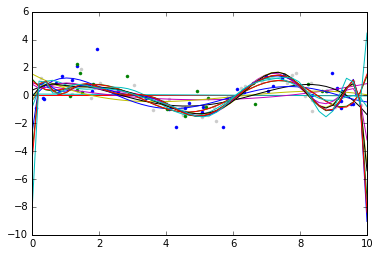

In [132]:
plt.plot(X[learn], Y[learn], ".", color="0.8")
plt.plot(X[valid], Y[valid], ".")
plt.plot(X[test], Y[test], ".")
err = []
for deg in range(16):
    poly = np.polyfit(X[learn], Y[learn], deg)
    x = np.linspace(0, Xmax)
    plt.plot(x, np.polyval(poly, x))
    sqerr = (np.polyval(poly, X) - Y)**2
    err.append([deg, np.mean(sqerr[learn]), np.mean(sqerr[valid]), np.mean(sqerr[test])])
err = np.array(err)

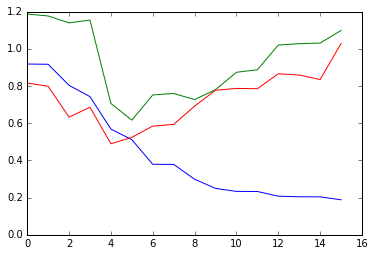

In [133]:
plt.plot(err[:,0], err[:,1], label="learn")
plt.plot(err[:,0], err[:,2], label="valid")
plt.plot(err[:,0], err[:,3], label="test")

## Jiný příklad

In [134]:
# http://www.sidc.be/silso/DATA/yearssn.dat
data = np.loadtxt("data/yearssn.dat")

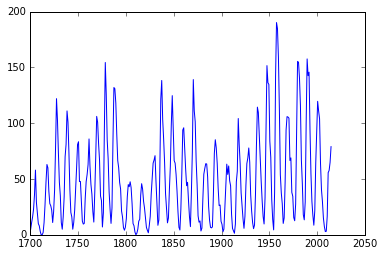

In [136]:
plt.plot(data[:,0], data[:,1])

In [137]:
# http://glowingpython.blogspot.cz/2015/01/forecasting-beer-consumption-with.html
def organize_data(to_forecast, window, horizon):
    """
     Input:
      to_forecast, univariate time series organized as numpy array
      window, number of items to use in the forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + \
            (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast, 
                                        shape=shape, 
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

k = 20   # number of previous observations to use
h = 7   # forecast horizon
X,y = organize_data(data[:,1], k, h)

In [150]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor


m = k+40 # number of samples to take in account
regressor = LinearRegression(normalize=True)
regressor = ElasticNet(normalize=True, alpha=0.01)
regressor = ElasticNet(normalize=True, alpha=0.001, positive=True)
regressor = KNeighborsRegressor(1, weights="distance")
regressor.fit(X[:m], y[:m])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='distance')

In [151]:
def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx]))
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

print('The error is %0.2f' % mape(regressor.predict(X[m:]),y[m:]))

The error is 2611.80


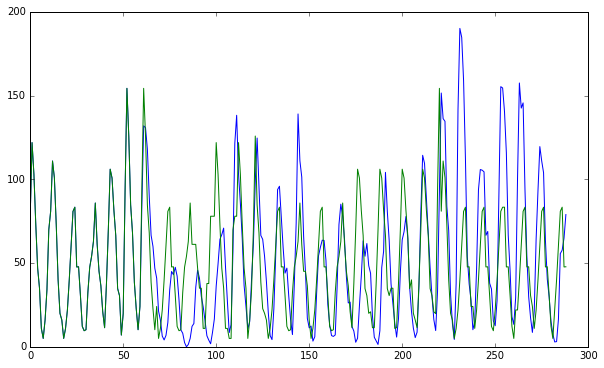

In [152]:
plt.figure(figsize=(10,6))
plt.plot(y)
eps=1e-3
plt.plot(regressor.predict(X+eps))

http://www.kurzweilai.net/machine-learning-helps-stanford-physicists-predict-dangerous-solar-flares-earlier

# Neparametrické modely

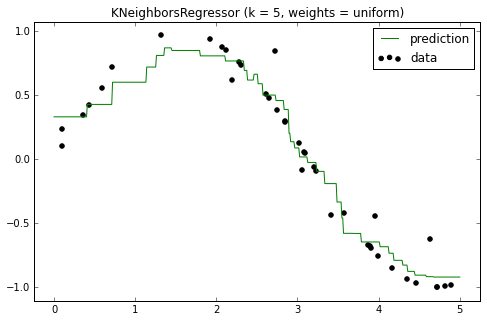

In [17]:
from sklearn import neighbors
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html
np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

###############################################################################
# Fit regression model
n_neighbors = 5

figure(figsize=(8,5))

knn = neighbors.KNeighborsRegressor(n_neighbors, weights="uniform")
y_ = knn.fit(X, y).predict(T)

plt.scatter(X, y, c='k', label='data')
plt.plot(T, y_, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = uniform)" % (n_neighbors,))

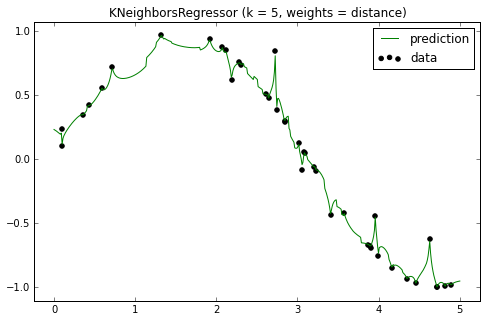

In [18]:
figure(figsize=(8,5))

knn = neighbors.KNeighborsRegressor(n_neighbors, weights="distance")
y_ = knn.fit(X, y).predict(T)

plt.scatter(X, y, c='k', label='data')
plt.plot(T, y_, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = distance)" % (n_neighbors,))

## Kernel density estimation
jádrový odhad hustoty

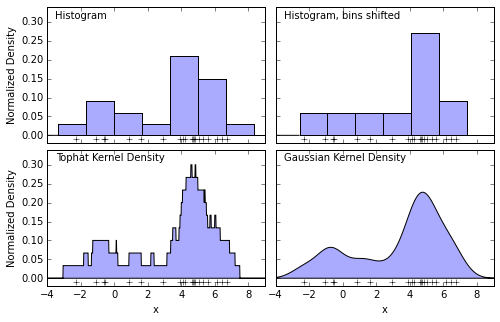

In [19]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity


#----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.concatenate((np.random.normal(0, 1, 0.3 * N),
                    np.random.normal(5, 1, 0.7 * N)))[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,5))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', normed=True)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', normed=True)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.zeros(X.shape[0]) - 0.01, '+k')
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('x')

# Klasifikace

## k-nearest neighbor

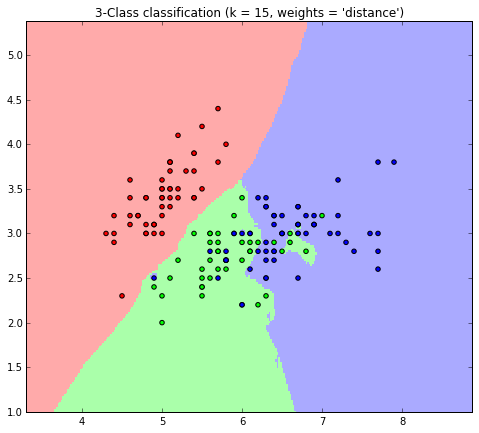

In [20]:
from matplotlib.colors import ListedColormap
from sklearn import datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

weights = 'distance'
# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,7))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
          % (n_neighbors, weights))

## Naive Bayes

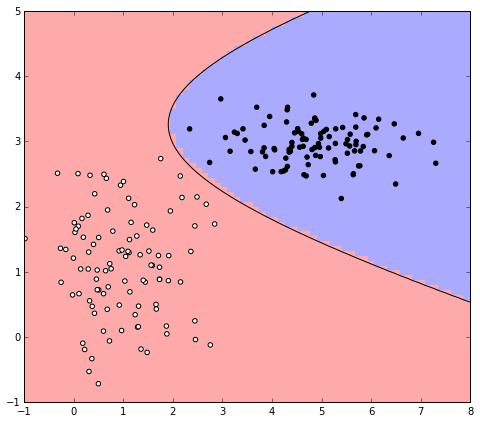

In [21]:
#http://www.astroml.org/book_figures/chapter9/fig_simple_naivebayes.html
from matplotlib import colors

from sklearn.naive_bayes import GaussianNB

#------------------------------------------------------------
# Simulate some data
np.random.seed(0)
mu1 = [1, 1]
cov1 = 0.6 * np.eye(2)

mu2 = [5, 3]
cov2 = np.eye(2) * np.array([1.0, 0.1])

X = np.concatenate([np.random.multivariate_normal(mu1, cov1, 100),
                    np.random.multivariate_normal(mu2, cov2, 100)])
y = np.zeros(200)
y[100:] = 1

#------------------------------------------------------------
# Fit the Naive Bayes classifier
clf = GaussianNB()
clf.fit(X, y)

# predict the classification probabilities on a grid
xlim = (-1, 8)
ylim = (-1, 5)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary, zorder=2)

ax.contour(xx, yy, Z, [0.5], colors='k')
cmap_light2 = ListedColormap(['#FFAAAA', '#AAAAFF'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light2)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

## Decision trees
rozhodovací stromy

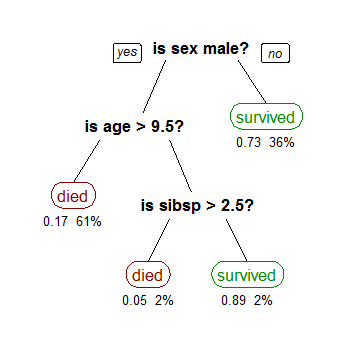

In [22]:
from IPython.display import Image
Image(filename='data/CART_tree_titanic_survivors.png')
#http://en.wikipedia.org/wiki/File:CART_tree_titanic_survivors.png

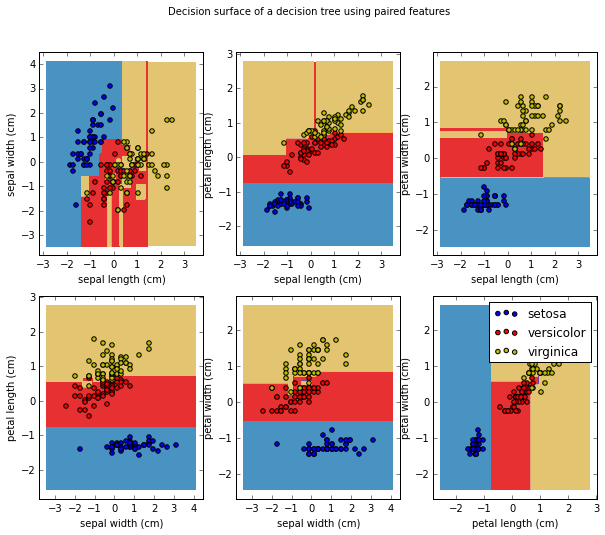

In [23]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

# Load data
iris = load_iris()

fig = plt.figure(figsize=(10, 8))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(13)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Standardize
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)

    plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()

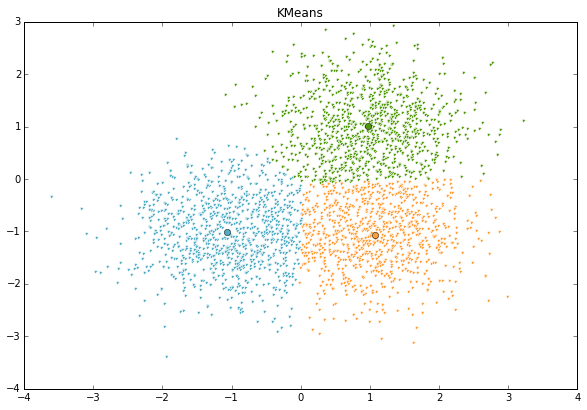

In [24]:
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

##############################################################################
# Generate sample data
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

##############################################################################
# Compute clustering with Means

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

##############################################################################
# Plot result

fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

ax = fig.add_subplot(111)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
